In [ ]:
using pulse_input_DDM, Revise
using PyPlot
using Parameters

In [ ]:
using Parameters

In [ ]:

abstract type DDM end
abstract type DDMdata end
abstract type DDMθ end
"""
"""
function createmodel(modelname)
    thetadict = Dict("expfilter" => θ_expfilter,
                     "expfilter_ce" => θ_expfilter_ce)

    thetazdict = Dict("expfilter" => θz_expfilter,
                    "expfilter_ce" => θz_expfilter_ce)

    optionsdict = Dict("expfilter" => choiceoptions_expfilter,
                    "expfilter_ce" => choiceoptions_expfilter_ce)

    if modelname in keys(thetadict)
        dimz = length(fieldnames(thetazdict[modelname])) 
        return dimz, thetadict[modelname](), optionsdict[modelname]()
    else
        error("Unknown model identifier $modelname")
    end
end

"""
"""
@with_kw struct θz_expfilter{T<:Real} @deftype T
    B = 15.
    λ = -0.5; @assert λ != 0.
    σ2_i = eps()
    σ2_a = 0.
    σ2_s = 2.
    ϕ = 0.2; @assert ϕ != 1.
    τ_ϕ = 0.05
    h_C = 0.3012
    h_eta = 0.9461
    h_beta = 0.1929
    h_drift_scale = 0.  # this turns on drift bias
end

"""
"""
@with_kw struct θz_expfilter_ce{T<:Real} @deftype T
    B = 15.
    λ = -0.5; @assert λ != 0.
    σ2_i = eps()
    σ2_a = 0.
    σ2_s = 2.5
    ϕ = 0.2; @assert ϕ != 1.
    τ_ϕ = 0.05
    h_etaC = 0.3012
    h_etaE = 0.3012
    h_betaC = 0.1929
    h_betaE = 0.1929
    h_drift_scale = 0.  # this turns on drift bias
end


"""
"""
@with_kw struct clicks
    L::Vector{Float64}
    R::Vector{Float64}
    T::Float64
end


"""
"""
@with_kw struct binned_clicks
    #clicks::T
    nT::Int
    nL::Vector{Int}
    nR::Vector{Int}
end


@with_kw struct bins
    #clicks::T
    xc::Vector{Real}
    dx::Real
    n::Int
end


"""
"""
@with_kw struct choiceinputs{T1,T2}
    clicks::T1
    binned_clicks::T2
    dt::Float64
    centered::Bool
end


"""
    θ_x{T1, T<:Real} <: DDMθ

Fields:

- `θz` is a type that contains the parameters related to the latent variable model.
- `bias` is the choice bias parameter.
- `lapse` is the lapse parameter.

Example:

```julia
θchoice(θz=θz(σ2_i = 0.5, B = 15., λ = -0.5, σ2_a = 50., σ2_s = 1.5,
    ϕ = 0.8, τ_ϕ = 0.05), bias=1., lapse=0.05)
```
"""
@with_kw struct θ_expfilter{T1, T<:Real} <: DDMθ
    θz::T1 = θz_expfilter()
    bias::T = 0.
    lapse::T = 0.01
end


@with_kw struct θ_expfilter_ce{T1, T<:Real} <: DDMθ
    θz::T1 = θz_expfilter_ce()
    bias::T = 0.
    lapse::T = 0.01
end




"""
    choicedata{T1} <: DDMdata

Fields:

- `click_data` is a type that contains all of the parameters related to click input.
- `choice` is the choice data for a single trial.

Example:

```julia
ntrials, dt, centered = 1, 1e-2, false
θ = θchoice()
clicks, choices = rand(θ, ntrials)
binned_clicks = bin_clicks(clicks, centered=centered, dt=dt)
inputs = choiceinputs(clicks, binned_clicks, dt, centered)
choicedata(inputs, choices)
```
"""
@with_kw struct choicedata{T1} <: DDMdata
    click_data::T1
    choice::Bool
    sessbnd::Bool
end


"""
    choiceDDM{T,U} <: DDM

Fields:

- `θ` is a type that contains all of the model parameters.
- `data` is a type that contains all of the data (inputs and choices).

Example:

```julia
ntrials, dt, centered = 1, 1e-2, false
θ = θchoice()
clicks, choices = rand(θ, ntrials)
binned_clicks = bin_clicks(clicks, centered=centered, dt=dt)
inputs = choiceinputs(clicks, binned_clicks, dt, centered)
data = choicedata(inputs, choices)
choiceDDM(θ, data)
```
"""
@with_kw struct choiceDDM{T,U} <: DDM
    θ::T = θchoice()
    data::U
end

"""
"""
@with_kw mutable struct choiceoptions_expfilter
    fit::Vector{Bool} = vcat(true, true, false, true, true, true, true, true, true, true, false, false, true)
    lb::Vector{Float64} = vcat([5., -5., 0., 0., 2., 0.01, 0.005, 0., 0., 0., 0.], [-30, 0.])
    ub::Vector{Float64} = vcat([60., 5., 2., 100., 20., 1.2, 1., 1., 1., 1., 1.], [30, 1.])
    x0::Vector{Float64} = vcat([15., -0.5, eps(), 2., 1.5, 0.2, 0.02, 0.3014, 0.9664, 0.3570, 0.], [0.,1e-4])
end

"""
"""
@with_kw mutable struct choiceoptions_expfilter_ce
    fit::Vector{Bool} = vcat(true, true, false, true, true, true, true, true, true, true, true, false, true, true)
    lb::Vector{Float64} = vcat([5., -5., 0., 0., 2., 0.01, 0.005, 0., 0., 0., 0., 0.], [-30, 0.])
    ub::Vector{Float64} = vcat([60., 5., 2., 100., 20., 1.2, 1., 1., 1., 1., 1., 1.], [30, 1.])
    x0::Vector{Float64} = vcat([15., -0.5, eps(), 2., 1.5, 0.2, 0.02, 0.3, 0.3, 0.1, 0.1, 0.], [0.,1e-4])
end

In [ ]:
modelname = "expfilter"
dimz,g, options = createmodel(modelname)

In [ ]:
h = g.θz

In [ ]:
dimz

In [ ]:
@unpack fit, lb, ub, x0 = options


In [ ]:
fit


In [ ]:
options


In [33]:
    ntrials = 100
    sessbnd = [rand()<0.001 for i in 1:ntrials]
    correct = [rand()<0.5 for i in 1:ntrials]
    choice = [rand()<0.5 for i in 1:ntrials]

    sessbnd[1] = 1

    etaC, etaE, betaC, betaE = 0.5, 0.5, 0.1, 0.2
    hits = correct .== choice

    i_0 = Array{Float64}(undef, length(correct))

    lim = 1
    for i = 1:length(correct)
        if sessbnd[i] == 1
            lim = i
            i_0[i] = 0.
            rel = []
        else
            rel = max(lim, i-10):i-1
            i_0[i] = sum(hits[rel].*etaC.*betaC.^reverse(0:length(rel)-1)) - sum((1 .- hits[rel]).*etaE.*betaE.^reverse(0:length(rel)-1))
        end
    end



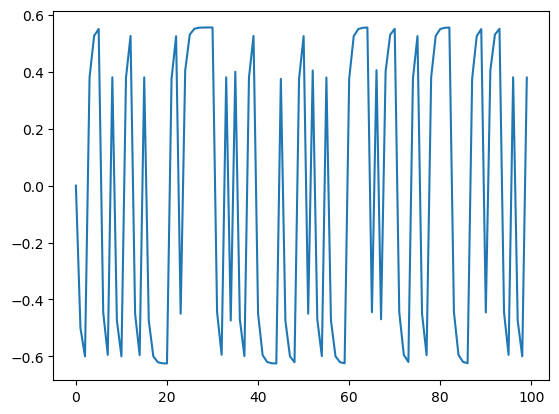

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13ed84d50>

In [34]:
using PyPlot
plot(i_0)


In [49]:
using pulse_input_DDM

┌ Info: Precompiling pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

